In [1]:
from collections import namedtuple
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import pandas as pd
from pathlib import Path
from functools import partial
import itertools
from itertools import combinations
import re
import requests
import json
import scipy as sp
import scipy.stats
import sklearn
import sys
import time
import pyext.src.pynet_rng as rng
import timeit
import pyext.src.matrix as mat
import pyext.src.stats as stats

from src.wishart_synthetic_benchmark import (
    ccscatter,
    check_cov,
    df_from_stats,
    get_precision_matrix_stats,
    get_prior_pred,
    helper_vline_hist,
    margins_plot,
    quad_plot,
    randPOSDEFMAT,
    rprior,
    rprior_pred,
    sample_from_prior,
    scatter_plot,
    simulate_from_prior,
    try_sampling,
    ground_truth_pair_plot
)

In [2]:
# Global Convience Settings

inv = sp.linalg.inv

In [94]:
# Global Experiment Settings
n_samples = 1000000
p = 16
nu = 15
Gkey = jax.random.PRNGKey(52)
diag_idx = np.diag_indices(p)
key, k1 = jax.random.split(Gkey, 2)
edge_prob = 0.1
A = jax.random.bernoulli(k1, p=edge_prob, shape=(p, p))
A = np.array(A)
A = np.tril(A, k=-1)
A = A + A.T
A[diag_idx] = 1

K_theta_scale = 0.4
K_theta_diag = 1.0

# Generate K_theta
key, k1 = jax.random.split(key, 2)
K_theta = jax.random.normal(k1, shape=(p, p)) * K_theta_scale
K_theta = np.array(K_theta)
K_theta = np.tril(K_theta, k=-1)
K_theta = K_theta + K_theta.T
K_theta[np.where(A==0)] = 0
K_theta[diag_idx] = K_theta_diag
check_cov(K_theta)

cov_theta = inv(K_theta)
# Plotting global settings

vscale = 1.5
vmin1 = -vscale
vmax1 = vscale

# Plotting strings
str_Sigma = "\N{greek capital letter sigma}"
str_Omega = "\N{greek capital letter omega}"
# divergent colormaps
cmap = "seismic"

# sequential colormaps
cmap_seq = "gnuplot2"
# Generate some data

def generate_synthetic_data(key, n_trial, cov):
    """
    normally distributed with means of 0
    """
    xp = jax.random.multivariate_normal(k1, jnp.zeros(p), cov, shape=(n_trial, )).T
    assert xp.shape == (len(cov), n_trial)
    return xp

def get_Un(key, n_trial, cov):
    x = generate_synthetic_data(key, n_trial, cov)
    Un = x @ x.T
    assert Un.shape == (p, p)
    Un = np.array(Un)
    return Un, x

def covaraince_data_plotter(cov, U, n_trials):
    # Plotting Data
    fig, axs = ground_truth_pair_plot(cov, U / n_trials,
                          vmin1=-1.5, vmax1=1.5, vmin2=-1.5, vmax2=1.5, overwrite_diags=False)


    axs[0].set_title(f"True population {str_Sigma}")
    axs[1].set_title(f"{n_trials}-trial linear combination of data from N(0, {str_Sigma})")
    plt.show()
    
def precision_data_plotter(K, Kdata, n_trials, title1=f"True population {str_Omega}",
                           title2=f"scaled inverse {n_trials}-trial linear combination of data from N(0, {str_Sigma})"):
    # Plotting Data
    fig, axs = ground_truth_pair_plot(K, Kdata,
                          vmin1=-1.5, vmax1=1.5, vmin2=-1.5, vmax2=1.5, overwrite_diags=False)


    axs[0].set_title(title1)
    axs[1].set_title(title2)
    plt.show()
    
def get_sigma_var_prior(x, p, uncertainty):
    SigmaVarPrior = np.eye(p)
    SigmaVarPrior[diag_idx] = np.var(x, axis=1) * uncertainty
    return SigmaVarPrior

axs[0].set_title(f"True population {str_Sigma}")
axs[1].set_title(f"4-replicate linear combination of data from N(0, {str_Sigma})")
plt.show()


key, k1 = jax.random.split(key)

U4, xp4 = get_Un(key, 4, cov_theta)
U12, xp12 = get_Un(key, 12, cov_theta)
U50, xp50 = get_Un(key, 50, cov_theta)
U1000, xp1000 = get_Un(key, 1000, cov_theta)


ground_truth_pair_plot = partial(ground_truth_pair_plot, vmin1=vmin1, vmax1=vmax1,
                                 vmin2=vmin1, vmax2=vmax1, cmap1=cmap, cmap2=cmap)

# Prior

SigmaPrior = 2 * np.eye(p)
Kprior = inv(SigmaPrior)
Vprior = Kprior / p

# Adding Information

K4 = inv(inv(Kprior) + U4 / 4)

nu4 = 4 + p
V4 = K4 / (nu4)

K12 = inv(inv(Kprior) + U12 / 12)
nu12 = 12 + p
V12 = K12 / (nu12)

# Variance Prior

sample_variance_uncertainty_factor = 1.1


SigmaVarPrior4 = get_sigma_var_prior(xp4, p,  sample_variance_uncertainty_factor)

Kvar4 = inv(SigmaVarPrior4 + U4 / 4)
Vvar4 = K4 / p


SigmaVarPrior12 = get_sigma_var_prior(xp12, p, sample_variance_uncertainty_factor)

Kvar12 = inv(SigmaVarPrior12 + U12/12)
Vvar12 = Kvar12 / p

SigmaVarPrior50 = get_sigma_var_prior(xp50, p, sample_variance_uncertainty_factor)
Kvar50 = inv(SigmaVarPrior50 + U50 / 50)
Vvar50 = Kvar50 / p

SigmaVarPrior1000 = get_sigma_var_prior(xp1000, p, sample_variance_uncertainty_factor)
Kvar1000 = inv(SigmaVarPrior1000 + U1000 / 1000)
Vvar1000 = Kvar1000 / p
for i in [Kvar4, Kvar12, Kvar50, Kvar1000, Vvar4, Vvar12, Vvar50, Vvar1000]:
    check_cov(i)


In [70]:
?get_sigma_var_prior

In [4]:
# Understanding Priors

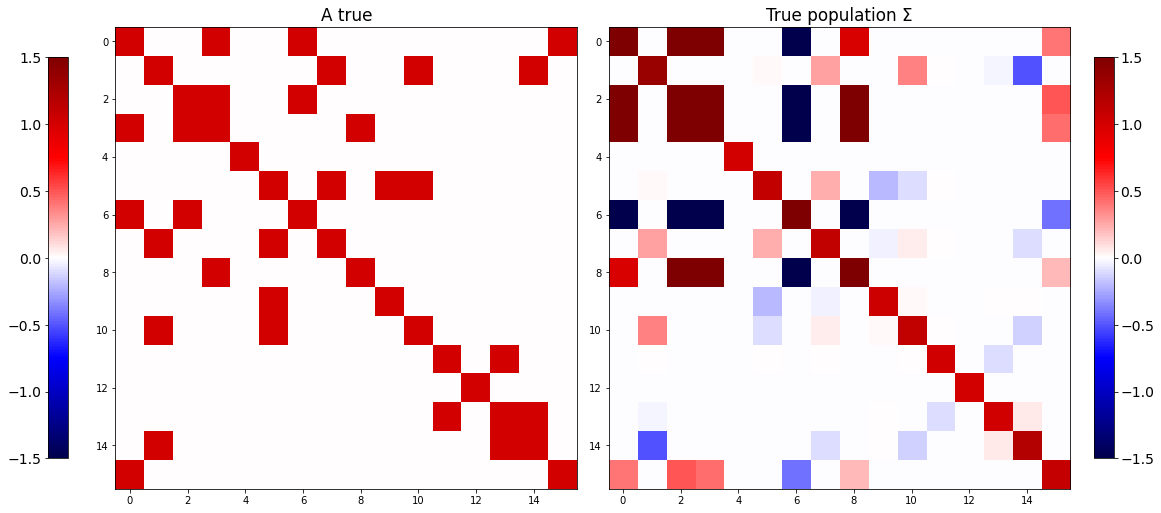

In [5]:
fig, axs = ground_truth_pair_plot(A, cov_theta,
                      vmin1=-1.5, vmax1=1.5, vmin2=-1.5, vmax2=1.5, overwrite_diags=False)

axs[0].set_title(f"A true")
axs[1].set_title(f"True population {str_Sigma}")
plt.show()

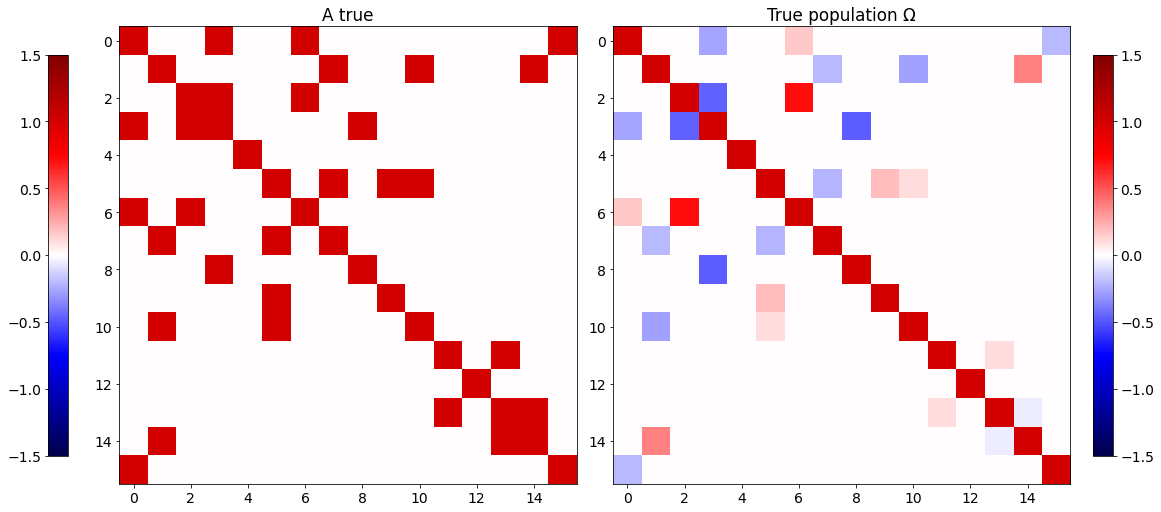

In [6]:
fig, axs = ground_truth_pair_plot(A, K_theta,
                      vmin1=-1.5, vmax1=1.5, vmin2=-1.5, vmax2=1.5, overwrite_diags=False)

axs[0].set_title(f"A true")
axs[1].set_title(f"True population {str_Omega}")
plt.show()

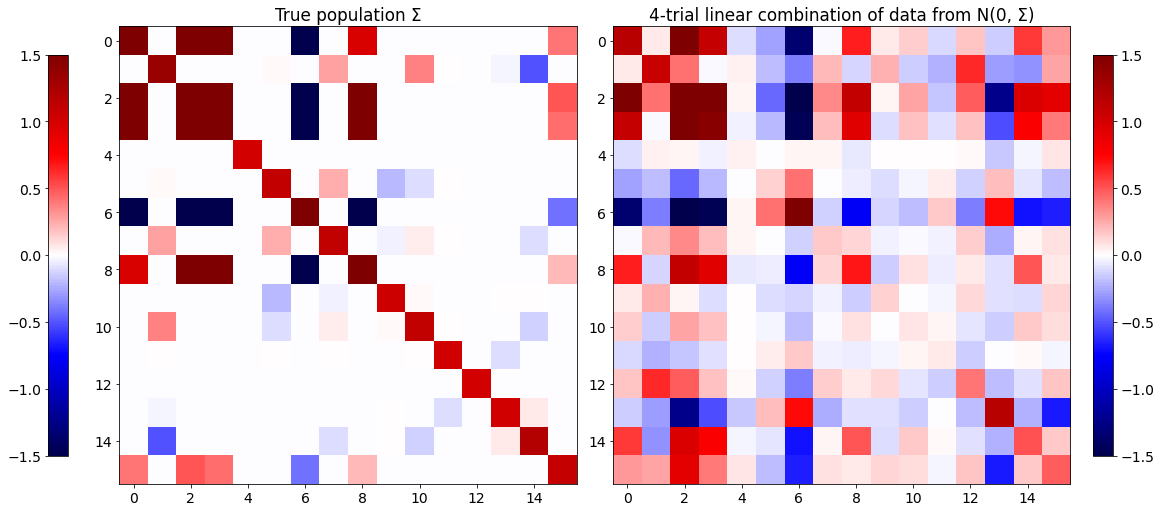

In [64]:
covaraince_data_plotter(cov_theta, U4 / 4, 4)

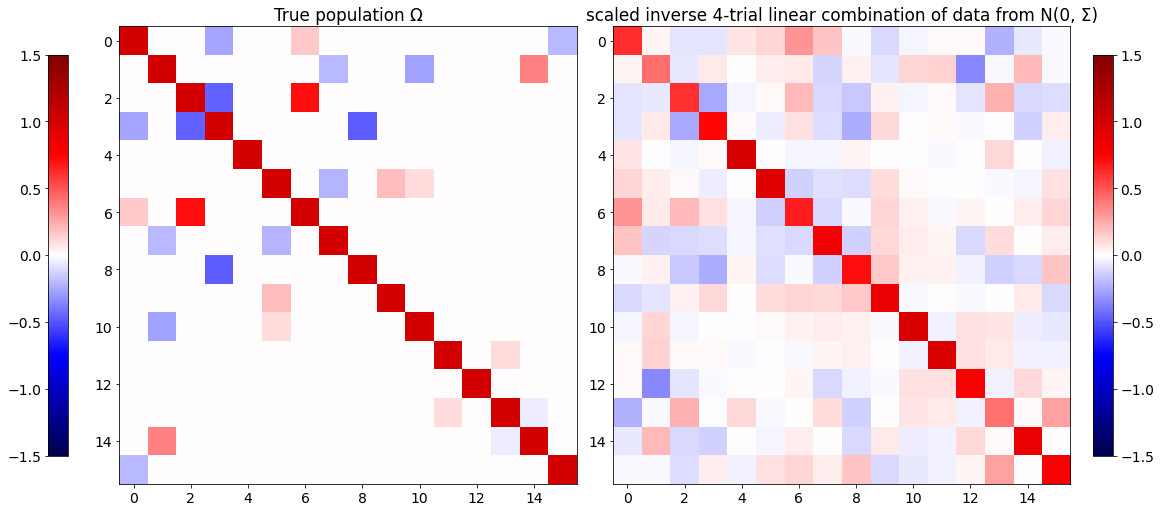

In [91]:
precision_data_plotter(K_theta, inv(U4 / 4 + np.eye(p) * 0.1) / 10, 4)

/tmp/ipykernel_203531/1545043254.py:4: RuntimeWarning: divide by zero encountered in log
  yval = np.log(ysum)


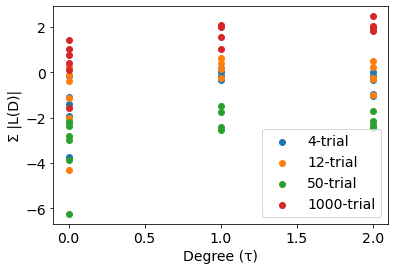

In [182]:
def degree_plot(A, B, label=None, log=False):
    ysum = np.sum(np.absolute(np.tril(B, k=-1)), axis=1)
    if log:
        yval = np.log(ysum)
    else:
        yval = ysum
        
    plt.scatter(np.sum(np.tril(A, k=-1), axis=1), yval, cmap=cmap, label=label)
    plt.xlabel("Degree (\N{greek small letter tau})")
    plt.ylabel(f"{str_Sigma} |L(D)|")

log_flag = True
degree_plot(A, inv(U4 / 4 + np.eye(p) * 0.1) / 10, label="4-trial", log=log_flag)
degree_plot(A, inv(U12 / 12 + np.eye(p) * 0.1) / 7, label="12-trial", log=log_flag)
degree_plot(A, inv(U50 / 50 + np.eye(p) * 0.1) / 14, label="50-trial", log=log_flag)
degree_plot(A, inv(U1000 / 1000 + np.eye(p) * 0.1)*14, label="1000-trial", log=log_flag)
plt.legend()

In [165]:
np.sum(np.tril(A, k=-1), axis=0)

array([3, 3, 2, 1, 0, 3, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

In [113]:
np.sum(A, axis=1)

array([4, 4, 3, 4, 1, 4, 3, 3, 2, 2, 3, 2, 1, 3, 3, 2])

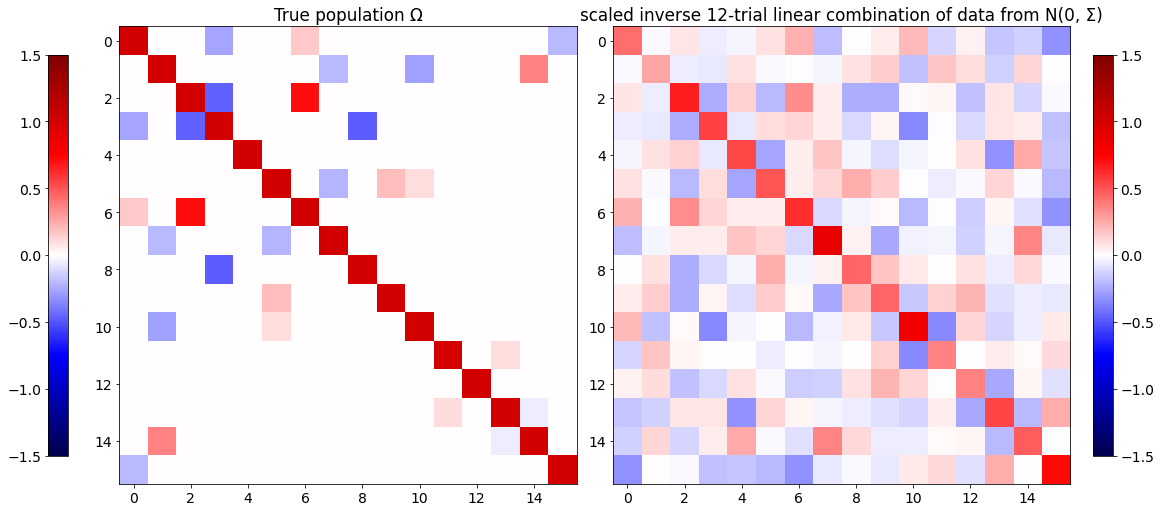

In [93]:
precision_data_plotter(K_theta, inv(U12 / 12 + np.eye(p) * 0.1) / 7, 12)

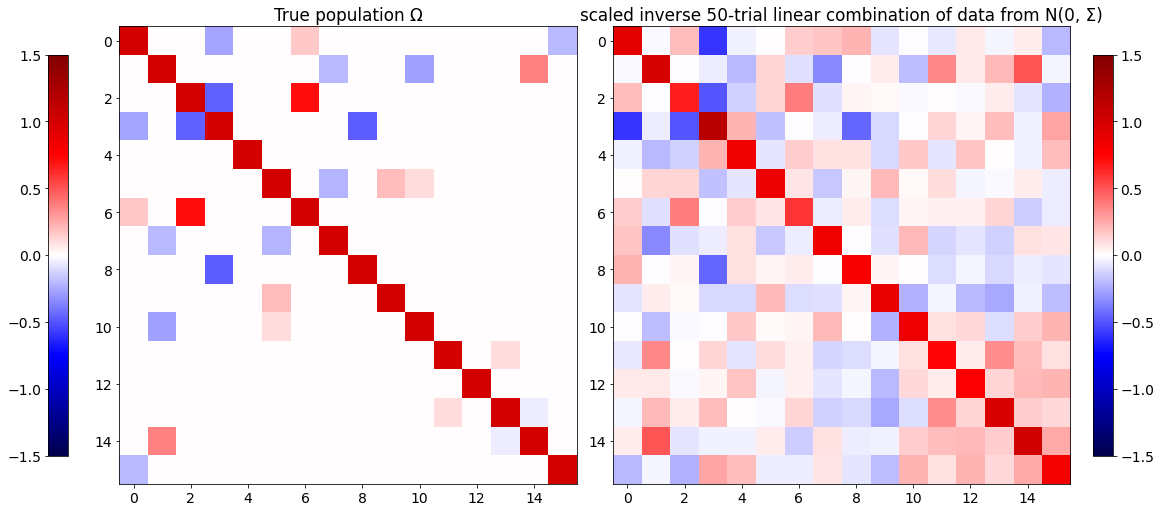

In [92]:
precision_data_plotter(K_theta, inv(U50 / 50 + np.eye(p) * 0.1) *0.7 , 50)

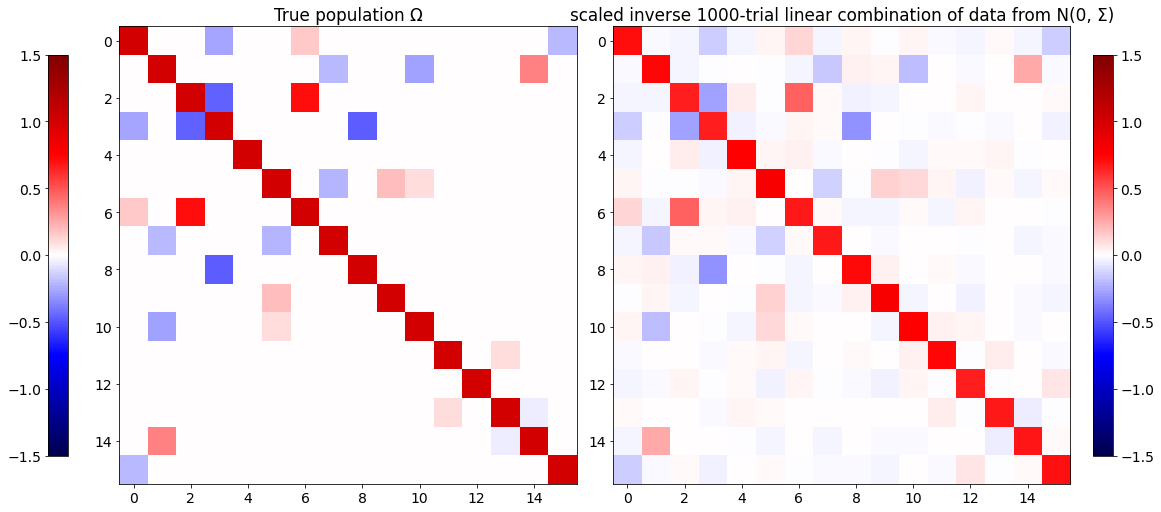

In [89]:
precision_data_plotter(K_theta, inv(U1000 / 50 + np.eye(p) * 0.1)*14, 1000)

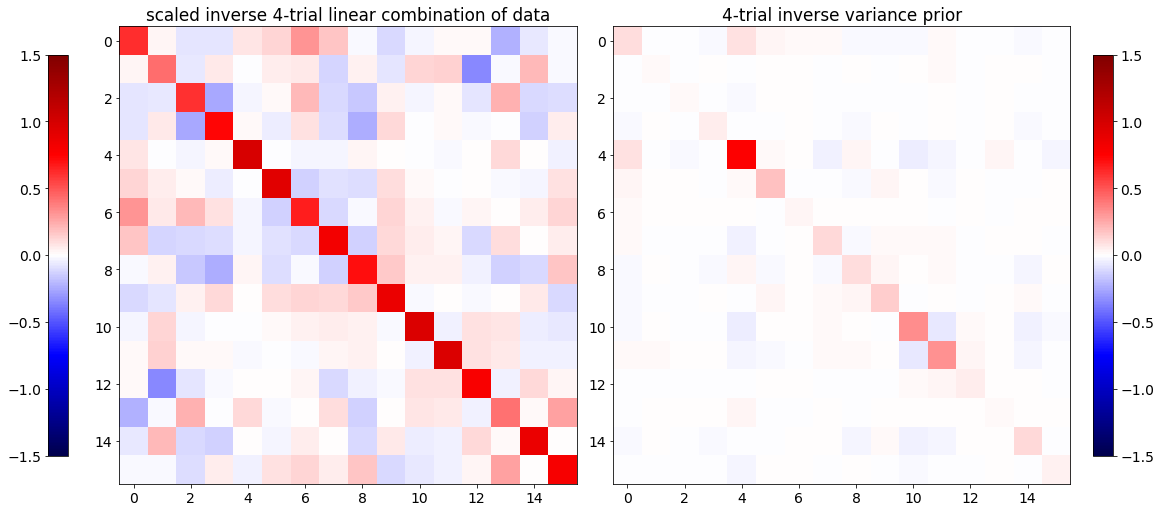

In [98]:
precision_data_plotter(inv(U4 / 4 + np.eye(p) * 0.1) / 10, inv(U4/4 + SigmaVarPrior4)/ 10, 4,
                       title1=f"scaled inverse 4-trial linear combination of data",
                       title2=f"4-trial inverse variance prior")

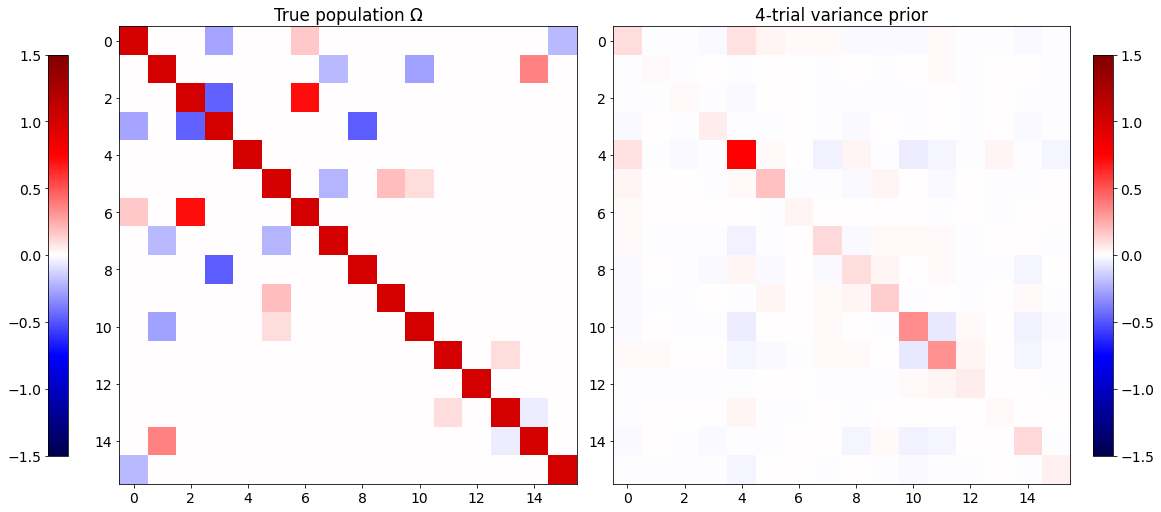

In [100]:
precision_data_plotter(K_theta, inv(U4/4 + SigmaVarPrior4)/ 10, 4,
                       title2=f"4-trial variance prior")

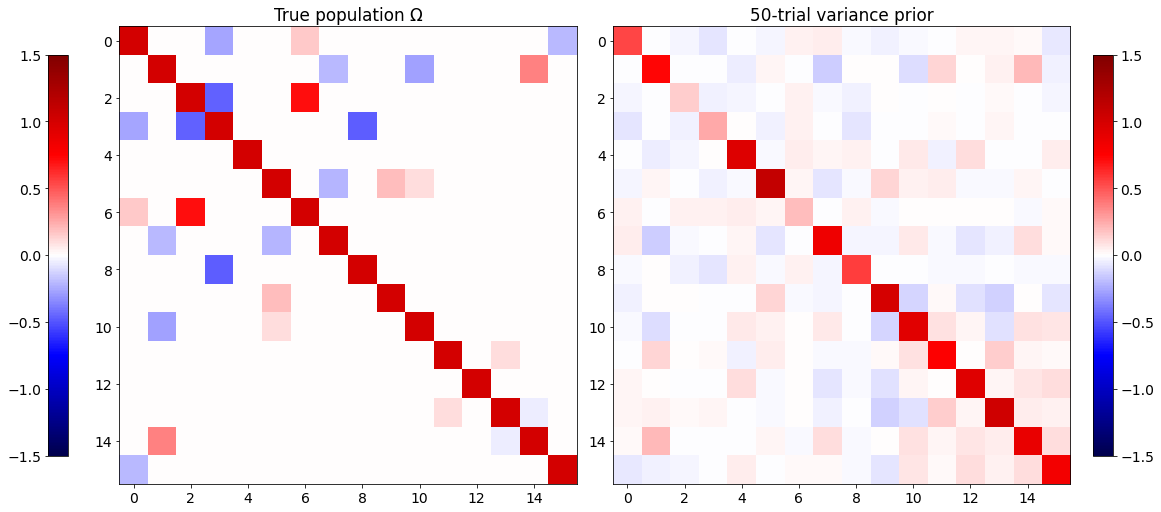

In [103]:
precision_data_plotter(K_theta, inv(U50/50 + SigmaVarPrior50)*2, 50,
                       title2=f"50-trial variance prior")

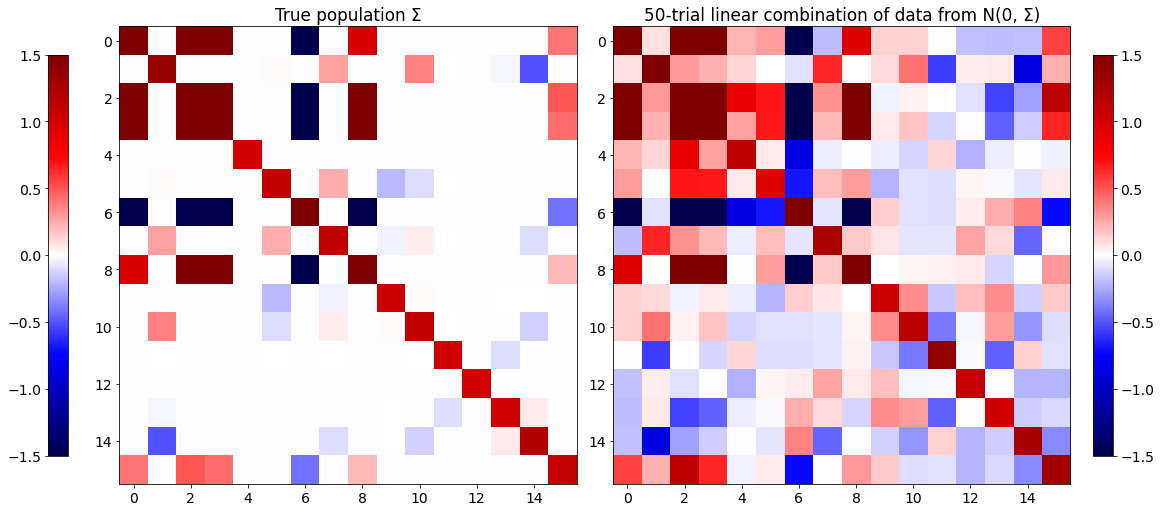

In [38]:
precision_data_plotter(K_theta, U4, 50)

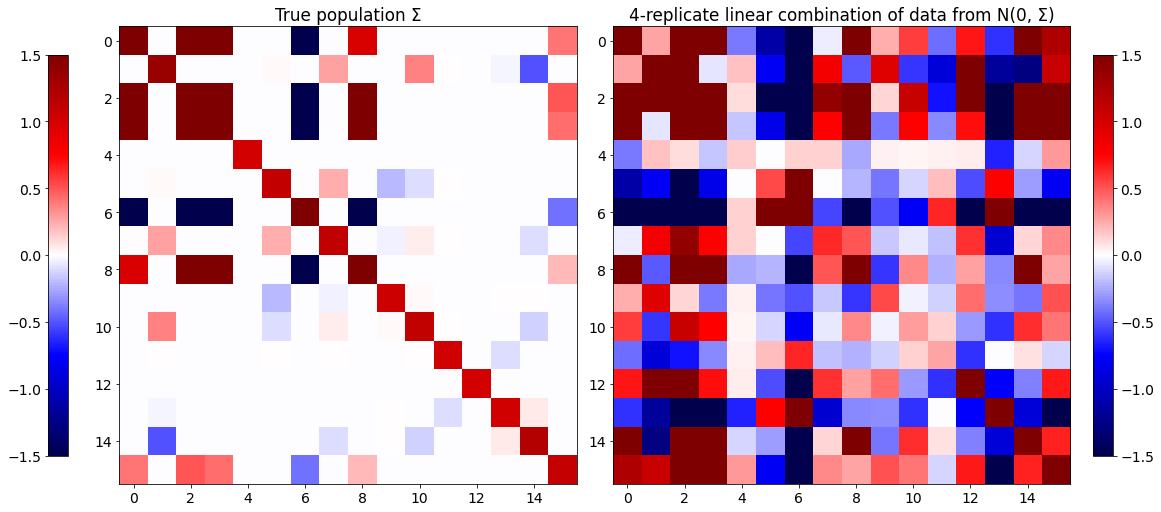

In [7]:
# Plotting Data
fig, axs = ground_truth_pair_plot(cov_theta, U4 / 4,
                      vmin1=-1.5, vmax1=1.5, vmin2=-1.5, vmax2=1.5, overwrite_diags=False)


axs[0].set_title(f"True population {str_Sigma}")
axs[1].set_title(f"4-replicate linear combination of data from N(0, {str_Sigma})")
plt.show()

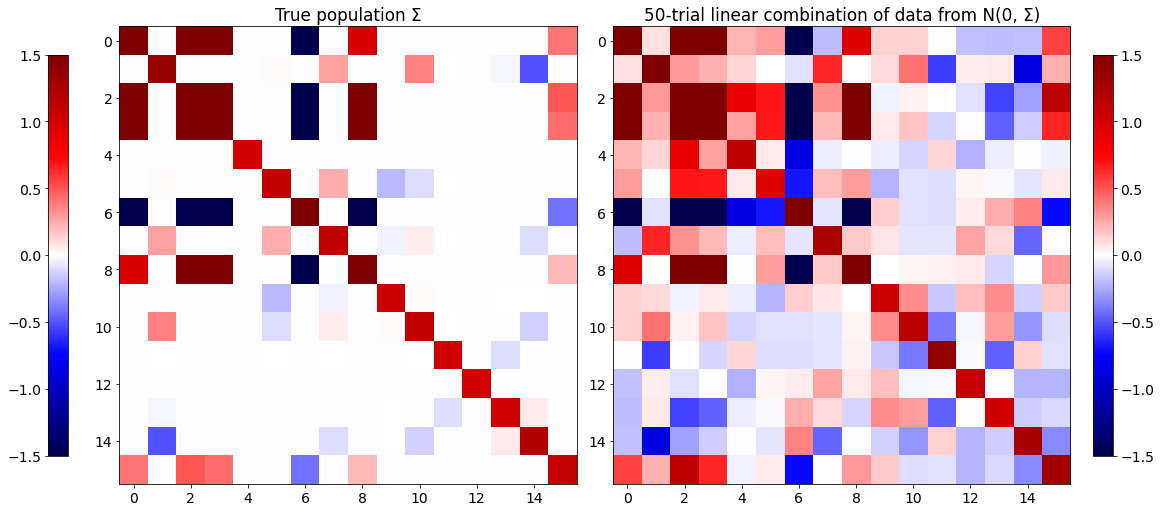

In [32]:
# Plotting Data
n_trials = 50
fig, axs = ground_truth_pair_plot(cov_theta, U50 / n_trials,
                      vmin1=-1.5, vmax1=1.5, vmin2=-1.5, vmax2=1.5, overwrite_diags=False)


axs[0].set_title(f"True population {str_Sigma}")
axs[1].set_title(f"{n_trials}-trial linear combination of data from N(0, {str_Sigma})")
plt.show()

In [8]:
np.min(cov_theta), np.max(cov_theta), np.min(U4 / (4)), np.max(U4 / (4))

(-5.6465783, 7.4409018, -9.204423, 12.534406)

In [9]:
np.min(cov_theta), np.max(cov_theta), np.min(U12 / (12)), np.max(U12 / (12))

(-5.6465783, 7.4409018, -4.3098226, 5.9333916)

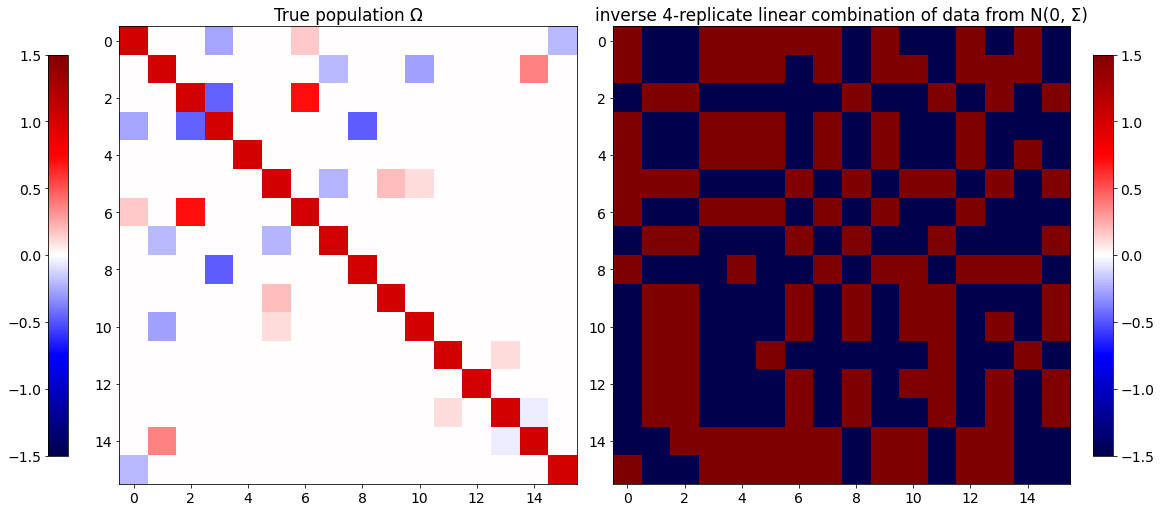

In [10]:
fig, axs = ground_truth_pair_plot(K_theta, inv(U4 / 4),
                      vmin1=-1.5, vmax1=1.5, vmin2=-1.5, vmax2=1.5, overwrite_diags=False)


axs[0].set_title(f"True population {str_Omega}")
axs[1].set_title(f"inverse 4-replicate linear combination of data from N(0, {str_Sigma})")
plt.show()

In [11]:
np.min(cov_theta), np.max(cov_theta)

(-5.6465783, 7.4409018)

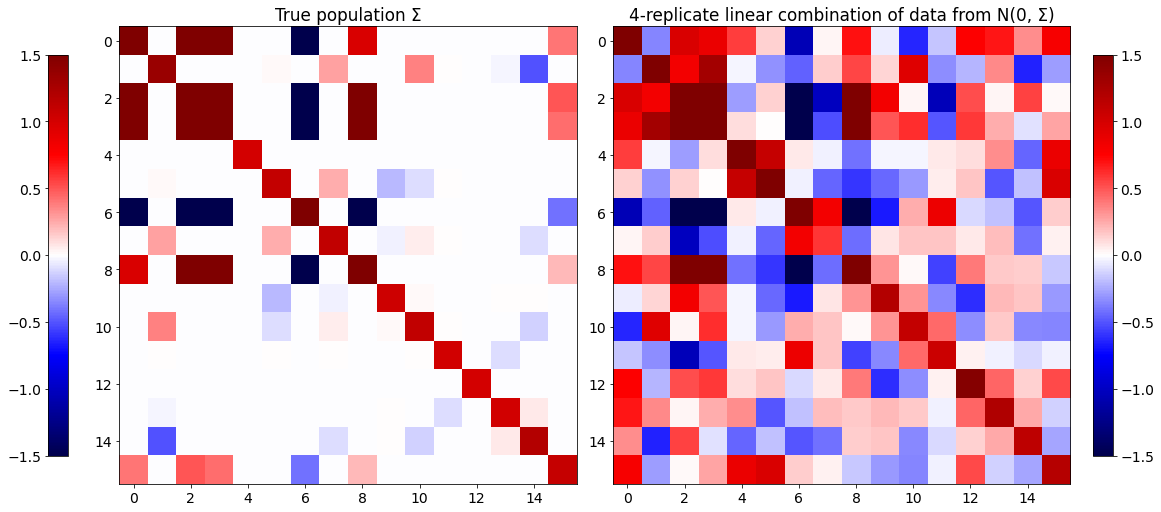

In [12]:
fig, axs = ground_truth_pair_plot(cov_theta, U12 / 12,
                      vmin1=-1.5, vmax1=1.5, vmin2=-1.5, vmax2=1.5, overwrite_diags=False)


axs[0].set_title(f"True population {str_Sigma}")
axs[1].set_title(f"4-replicate linear combination of data from N(0, {str_Sigma})")
plt.show()

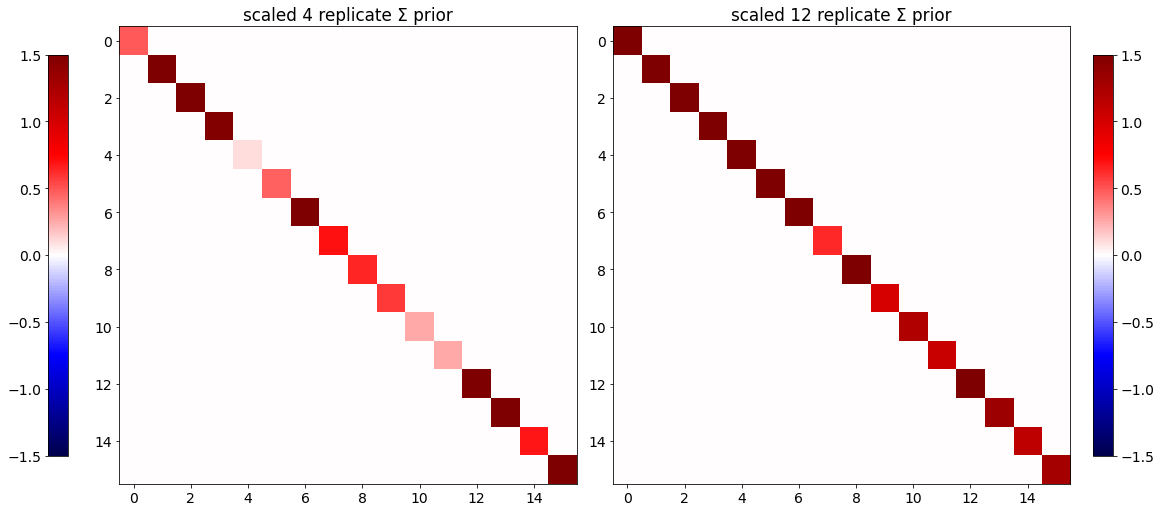

In [13]:
fig, axs = ground_truth_pair_plot(SigmaVarPrior4, SigmaVarPrior12,
                      vmin1=-1.5, vmax1=1.5, vmin2=-1.5, vmax2=1.5, overwrite_diags=False)

axs[0].set_title(f"scaled 4 replicate \N{greek capital letter sigma} prior")
axs[1].set_title(f"scaled 12 replicate \N{greek capital letter sigma} prior")
plt.show()

Text(0, 0.5, 'Diagonal of scaled dot-product')

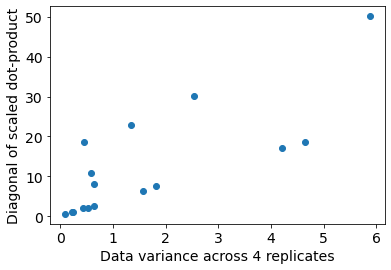

In [14]:
plt.scatter(np.var(xp4, axis=1), U4[diag_idx])
plt.xlabel("Data variance across 4 replicates")
plt.ylabel("Diagonal of scaled dot-product")

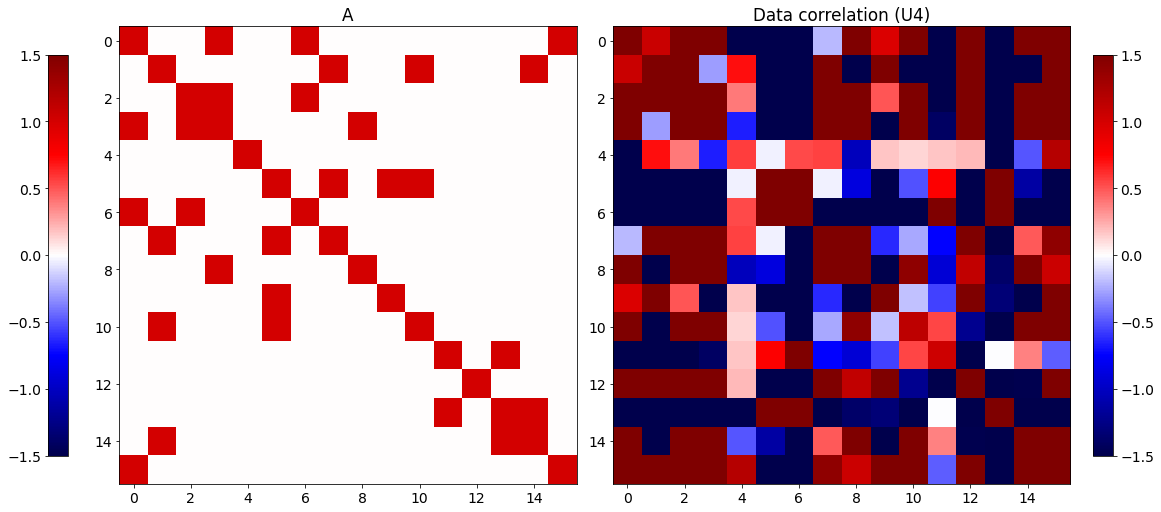

In [15]:
fig, axs = ground_truth_pair_plot(A, U4, cmap1=cmap, 
                       cmap2=cmap, 
                       vmin1=vmin1, vmin2=vmin1,
                       vmax1=vmax1, vmax2=vmax1, overwrite_diags=False)

axs[0].set_title("A")
axs[1].set_title("Data correlation (U4)") # \N{greek capital letter sigma}
plt.show()

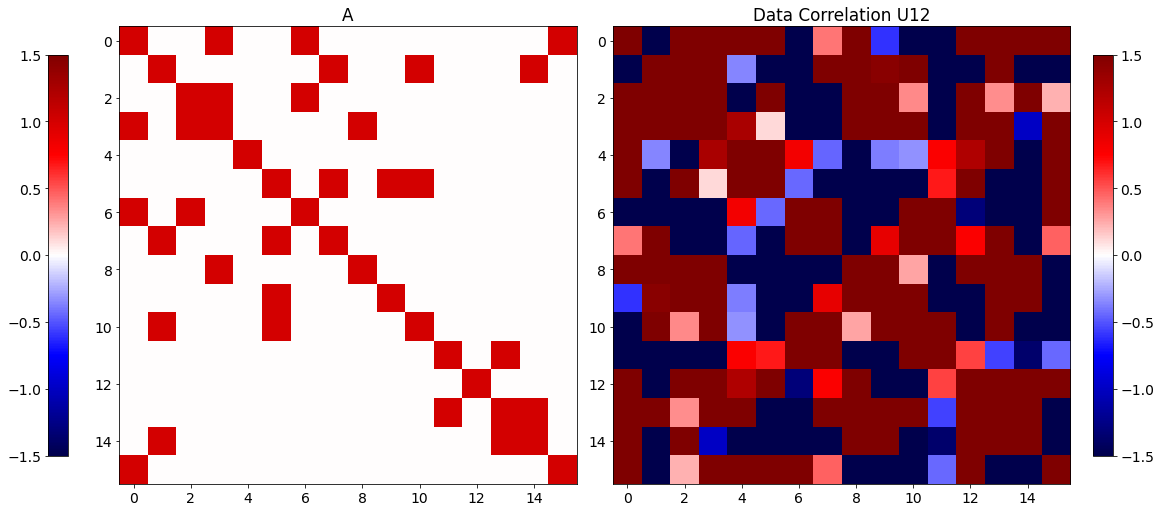

In [16]:
fig, axs = ground_truth_pair_plot(A, U12, cmap1=cmap, 
                       cmap2=cmap, 
                       vmin1=vmin1, vmin2=vmin1,
                       vmax1=vmax1, vmax2=vmax1, overwrite_diags=False)

axs[0].set_title("A")
axs[1].set_title("Data Correlation U12")
plt.show()

In [17]:
exp = sample_from_prior(key, nu, p, n_samples, Vprior)

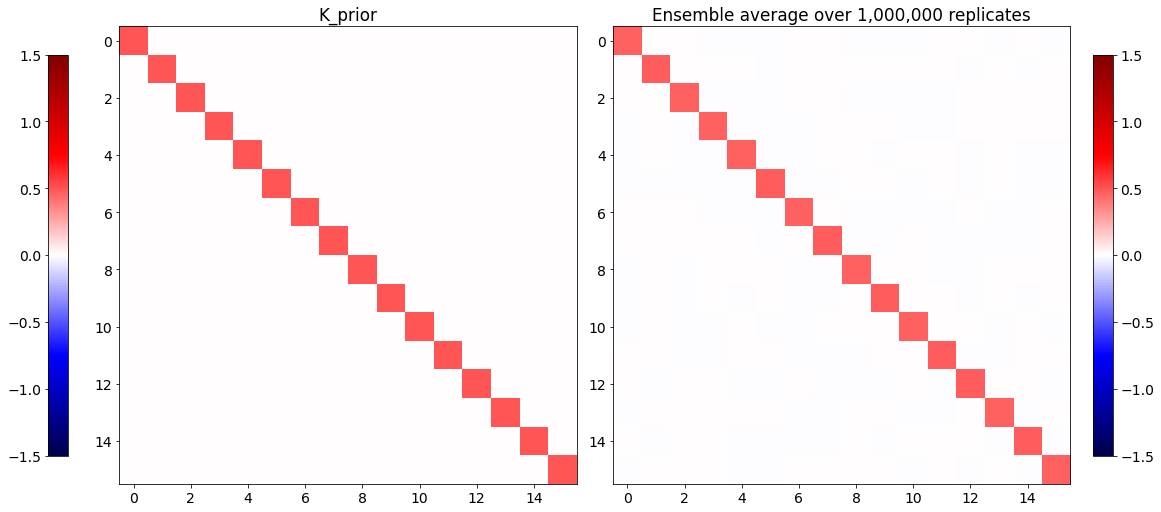

In [18]:
fig, axs = ground_truth_pair_plot(Kprior, np.array(np.mean(exp.samples, axis=0)), overwrite_diags=False)
axs[0].set_title("K_prior")
axs[1].set_title(f"Ensemble average over {'{:,}'.format(n_samples)} replicates")
plt.show()

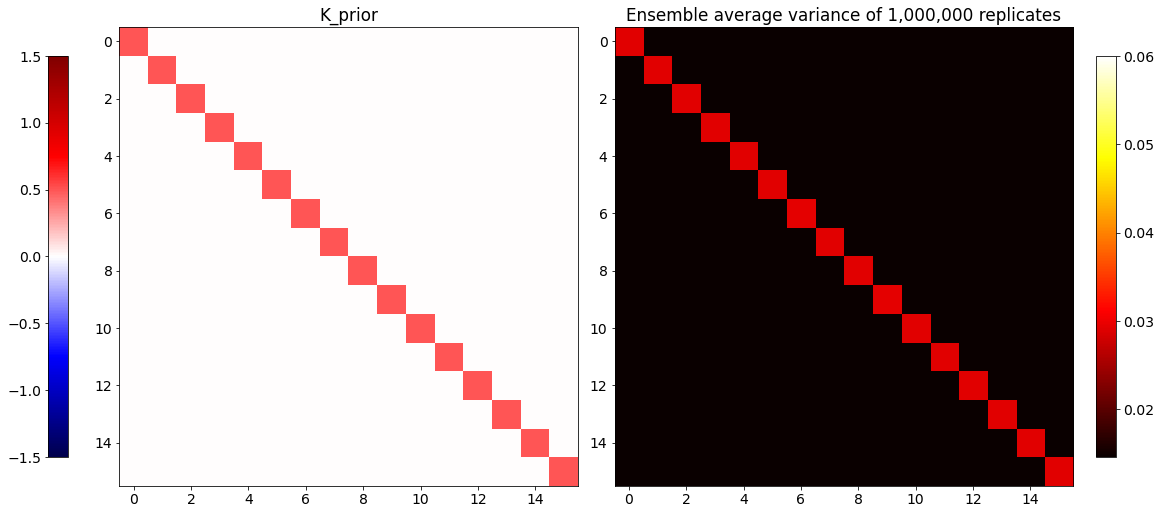

In [19]:
fig, axs = ground_truth_pair_plot(Kprior, 
                                  np.array(np.var(exp.samples, axis=0)), 
                                  cmap2= "hot",#cmap_seq,
                                  vmin2=0, vmax2=0.06,
                                  overwrite_diags=False)
axs[0].set_title("K_prior")
axs[1].set_title(f"Ensemble average variance of {'{:,}'.format(n_samples)} replicates")
plt.show()

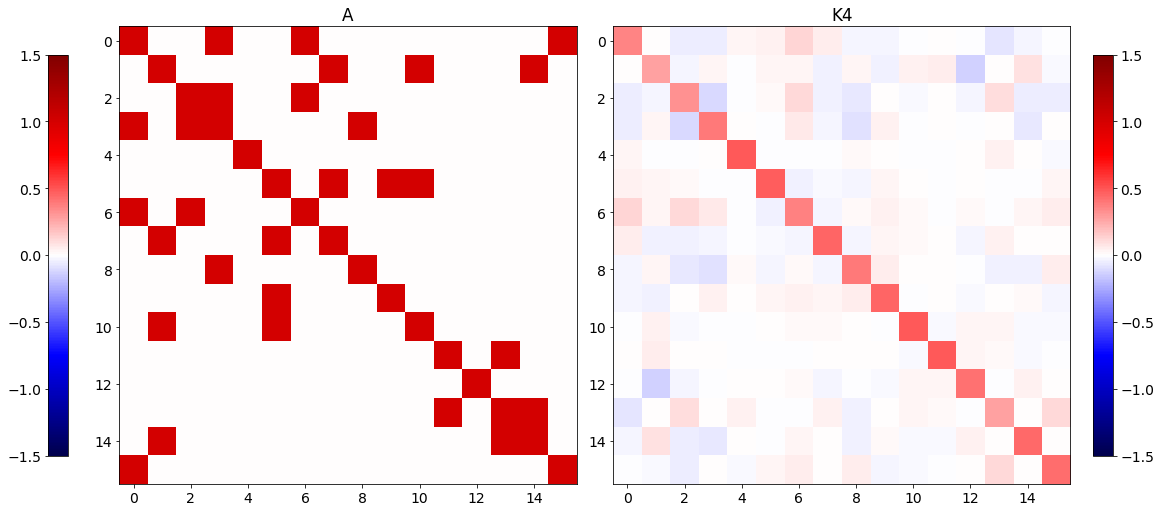

In [20]:
fig, axs = ground_truth_pair_plot(A, K4, cmap1=cmap, 
                       cmap2=cmap, 
                       vmin1=vmin1, vmin2=vmin1,
                       vmax1=vmax1, vmax2=vmax1, overwrite_diags=False)

axs[0].set_title("A")
axs[1].set_title("K4")
plt.show()

In [21]:
exp = sample_from_prior(key, nu4, p, n_samples, V4)

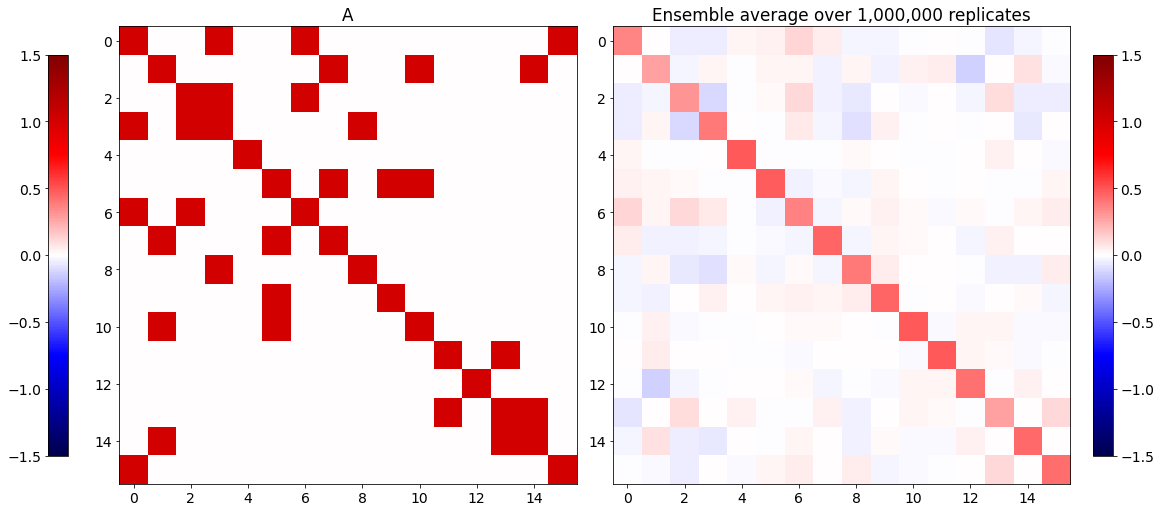

In [22]:
fig, axs = ground_truth_pair_plot(A, np.array(np.mean(exp.samples, axis=0)), overwrite_diags=False)
axs[0].set_title("A")
axs[1].set_title(f"Ensemble average over {'{:,}'.format(n_samples)} replicates")
plt.show()

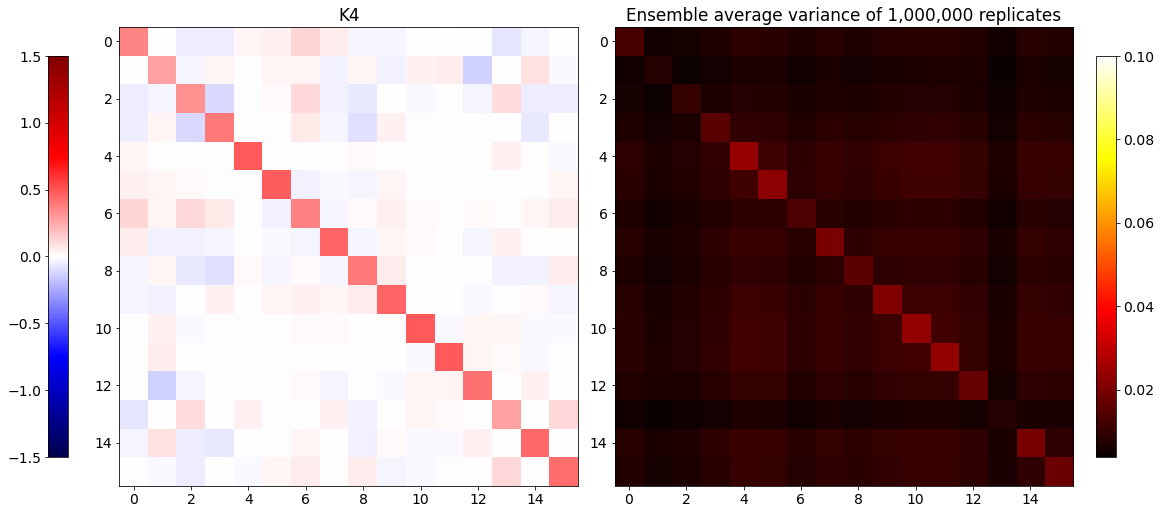

In [23]:
fig, axs = ground_truth_pair_plot(K4, 
                                  np.array(np.var(exp.samples, axis=0)), 
                                  cmap2= "hot",#cmap_seq,
                                  vmin2=0, vmax2=0.1,
                                  overwrite_diags=False)
axs[0].set_title("K4")
axs[1].set_title(f"Ensemble average variance of {'{:,}'.format(n_samples)} replicates")
plt.show()

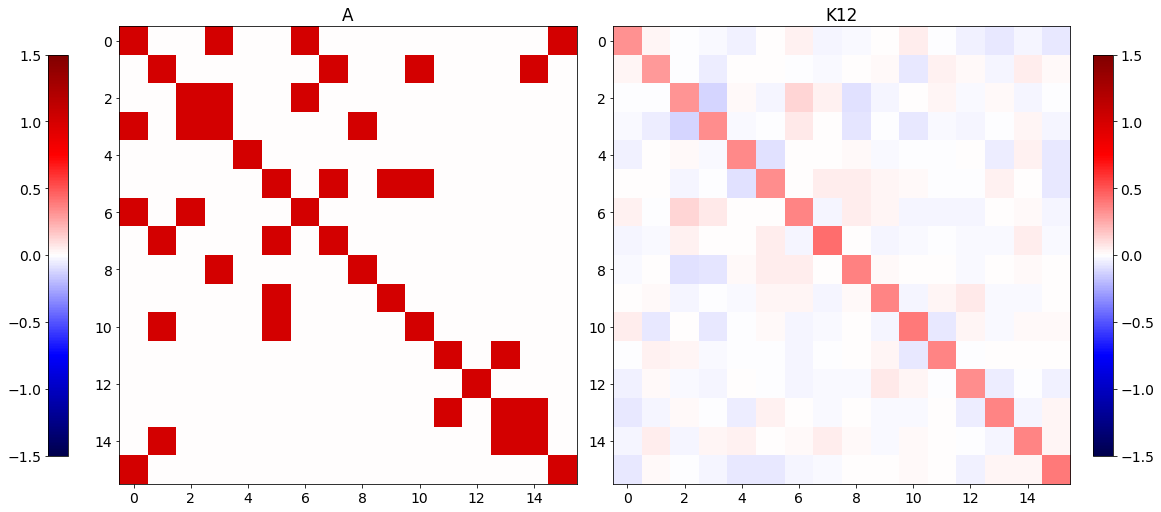

In [24]:
fig, axs = ground_truth_pair_plot(A, K12, cmap1=cmap, 
                       cmap2=cmap, 
                       vmin1=vmin1, vmin2=vmin1,
                       vmax1=vmax1, vmax2=vmax1, overwrite_diags=False)

axs[0].set_title("A")
axs[1].set_title("K12")
plt.show()

In [25]:
exp = sample_from_prior(key, nu12, p, n_samples, V12)

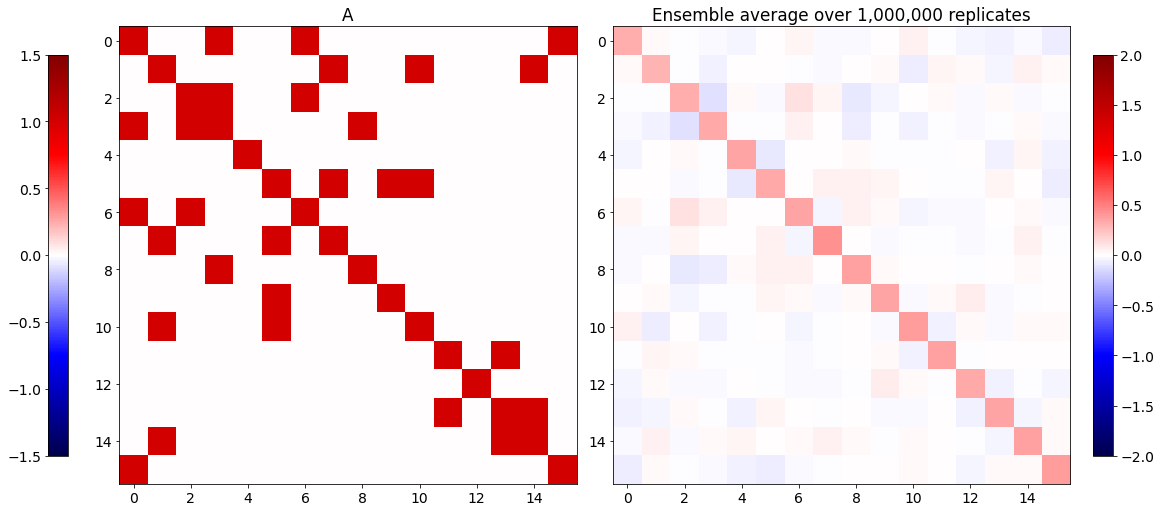

In [26]:
fig, axs = ground_truth_pair_plot(A, np.array(np.mean(exp.samples, axis=0)), overwrite_diags=False,
                                 vmin2=-2, vmax2=2)
axs[0].set_title("A")
axs[1].set_title(f"Ensemble average over {'{:,}'.format(n_samples)} replicates")
plt.show()

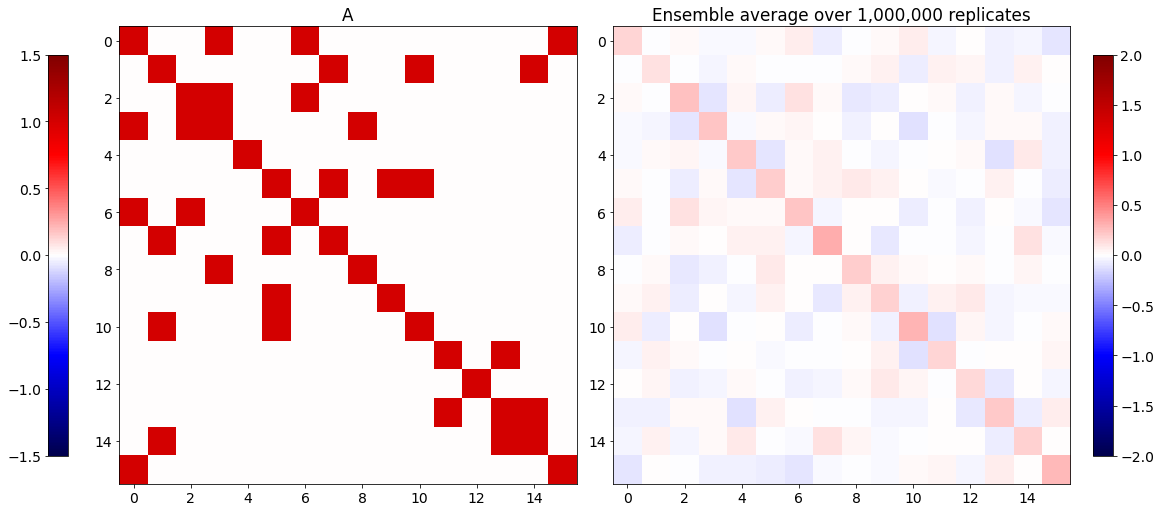

In [27]:
fig, axs = ground_truth_pair_plot(A, inv(np.eye(p)*2 + U12), overwrite_diags=False,
                                 vmin2=-2, vmax2=2)
axs[0].set_title("A")
axs[1].set_title(f"Ensemble average over {'{:,}'.format(n_samples)} replicates")
plt.show()

In [28]:
exp = sample_from_prior(key, 15, p, n_samples, Vvar4)

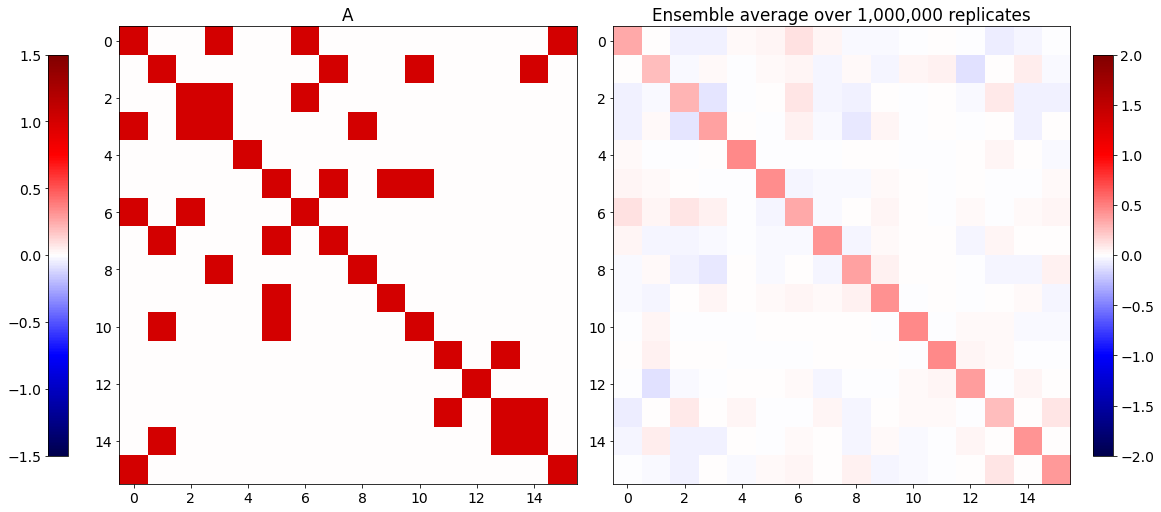

In [29]:
# 4 replicate Plot

fig, axs = ground_truth_pair_plot(A, np.array(np.mean(exp.samples, axis=0)), overwrite_diags=False,
                                 vmin2=-2, vmax2=2)
axs[0].set_title("A")
axs[1].set_title(f"Ensemble average over {'{:,}'.format(n_samples)} replicates")
plt.show()

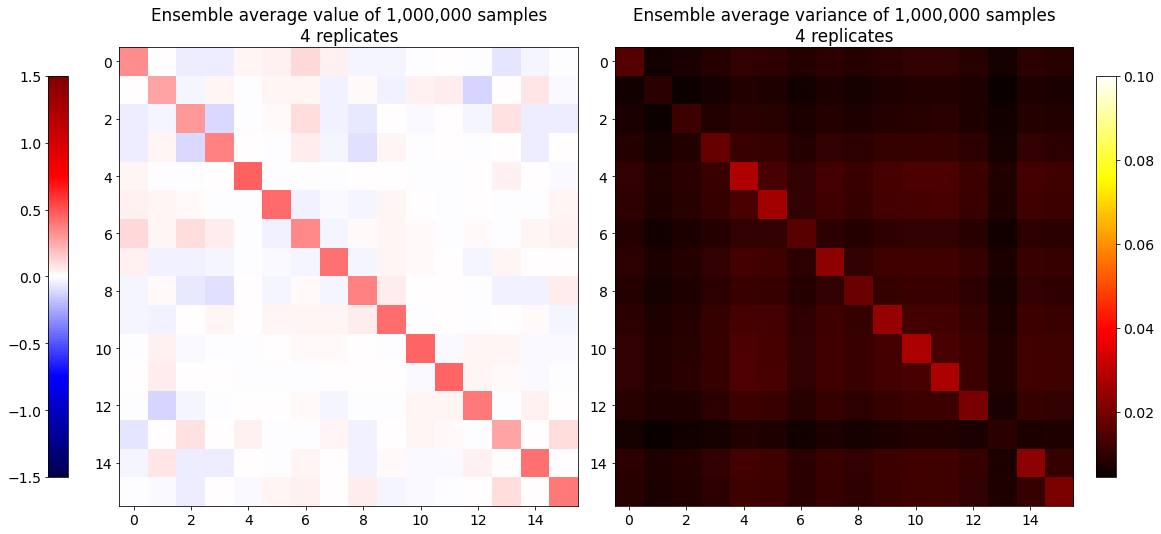

In [30]:
fig, axs = ground_truth_pair_plot(np.array(np.mean(exp.samples, axis=0)), 
                                  np.array(np.var(exp.samples, axis=0)), 
                                  cmap2= "hot",#cmap_seq,
                                  vmin2=0, vmax2=0.1,
                                  overwrite_diags=False)
axs[0].set_title(f"Ensemble average value of {'{:,}'.format(n_samples)} samples\n4 replicates")
axs[1].set_title(f"Ensemble average variance of {'{:,}'.format(n_samples)} samples\n4 replicates")
plt.show()

The regions of less information contain higher average variance across the ensemble